# Local Image Classification Training - Bars

Classifies the bars to extract the bits they represent.

In [1]:
BARS_FOLDER = "../bars/"
TRAIN_FOLDER = "../bars/train/"
TEST_FOLDER = "../bars/test/"
AUGMENT_FOLDER = "../bars/augmented/"
PARTITION_SCRIPT = "../tensorflow/scripts/preprocessing/partition_dataset.py"

In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import os

In [3]:
train_paths = [TRAIN_FOLDER + f for f in listdir(TRAIN_FOLDER) if isfile(join(TRAIN_FOLDER, f))]
test_paths = [TEST_FOLDER + f for f in listdir(TEST_FOLDER) if isfile(join(TEST_FOLDER, f))]

## Create a DataFrame with Paths and Labels

In [4]:
train_df = pd.DataFrame({'path': train_paths})
train_df["dec"] = train_df.apply(lambda x: int(x['path'].split("/")[-1].split("_")[0]), axis=1)
train_df["bin"] = train_df.apply(lambda x: bin(x['dec']), axis=1)
train_df["class"] = train_df.apply(lambda x: [i for i in reversed(range(20)) if (x['dec'] & 1 << i) != 0], axis=1)
    
print(train_df.shape)
train_df.head()

(1780, 4)


,path,dec,bin,class
0,../bars/train/1000082_v_300079.png,1000082,0b11110100001010010010,"[19, 18, 17, 16, 14, 9, 7, 4, 1]"
1,../bars/train/1000160_h_1016272.png,1000160,0b11110100001011100000,"[19, 18, 17, 16, 14, 9, 7, 6, 5]"
2,../bars/train/1000183_hv_915487.png,1000183,0b11110100001011110111,"[19, 18, 17, 16, 14, 9, 7, 6, 5, 4, 2, 1, 0]"
3,../bars/train/1000235_v_871471.png,1000235,0b11110100001100101011,"[19, 18, 17, 16, 14, 9, 8, 5, 3, 1, 0]"
4,../bars/train/1002732_hv_242463.png,1002732,0b11110100110011101100,"[19, 18, 17, 16, 14, 11, 10, 7, 6, 5, 3, 2]"


In [5]:
test_df = pd.DataFrame({'path': test_paths})
test_df["dec"] = test_df.apply(lambda x: int(x['path'].split("/")[-1].split("_")[0]), axis=1)
test_df["bin"] = test_df.apply(lambda x: bin(x['dec']), axis=1)
test_df["class"] = test_df.apply(lambda x: [i for i in reversed(range(20)) if (x['dec'] & 1 << i) != 0], axis=1)
    
print(test_df.shape)
test_df.head()

(200, 4)


,path,dec,bin,class
0,../bars/test/1000767_h_1018431.png,1000767,0b11110100010100111111,"[19, 18, 17, 16, 14, 10, 8, 5, 4, 3, 2, 1, 0]"
1,../bars/test/1001347_v_794159.png,1001347,0b11110100011110000011,"[19, 18, 17, 16, 14, 10, 9, 8, 7, 1, 0]"
2,../bars/test/1002872_1.png,1002872,0b11110100110101111000,"[19, 18, 17, 16, 14, 11, 10, 8, 6, 5, 4, 3]"
3,../bars/test/1004288_h_1024768.png,1004288,0b11110101001100000000,"[19, 18, 17, 16, 14, 12, 9, 8]"
4,../bars/test/1007758_h_1019981.png,1007758,0b11110110000010001110,"[19, 18, 17, 16, 14, 13, 7, 3, 2, 1]"


## Define the Image Generators

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_datagen = ImageDataGenerator(
      rotation_range = 4,
      zoom_range = 0.02,
      brightness_range=[0.15,0.85],
      channel_shift_range=0.2,
      shear_range = 0.2,
      horizontal_flip = False,
      vertical_flip = False,
      fill_mode = 'nearest')

In [8]:
target_size = (450, 100)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = ".",
    target_size = target_size,
    batch_size = 64,
    x_col = 'path',
    y_col = 'class',
    class_mode = 'categorical')
#   save_to_dir = '../augmented_bars/'

Found 1780 validated image filenames belonging to 20 classes.


In [10]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = ".",
    target_size = target_size,
    shuffle = False,
    x_col = 'path',
    y_col = 'class',
    class_mode = 'categorical')

Found 200 validated image filenames belonging to 20 classes.


## Define the Model

### Load model for transfer learning

In [12]:
from tensorflow.keras.applications import EfficientNetB1

model = EfficientNetB1(include_top=False, input_shape=(450,100,3))
#model.trainable = False

In [17]:
[(i,x.name) for i, x in enumerate(model.layers)]

[(0, 'input_2'),
 (1, 'rescaling_1'),
 (2, 'normalization_1'),
 (3, 'stem_conv_pad'),
 (4, 'stem_conv'),
 (5, 'stem_bn'),
 (6, 'stem_activation'),
 (7, 'block1a_dwconv'),
 (8, 'block1a_bn'),
 (9, 'block1a_activation'),
 (10, 'block1a_se_squeeze'),
 (11, 'block1a_se_reshape'),
 (12, 'block1a_se_reduce'),
 (13, 'block1a_se_expand'),
 (14, 'block1a_se_excite'),
 (15, 'block1a_project_conv'),
 (16, 'block1a_project_bn'),
 (17, 'block1b_dwconv'),
 (18, 'block1b_bn'),
 (19, 'block1b_activation'),
 (20, 'block1b_se_squeeze'),
 (21, 'block1b_se_reshape'),
 (22, 'block1b_se_reduce'),
 (23, 'block1b_se_expand'),
 (24, 'block1b_se_excite'),
 (25, 'block1b_project_conv'),
 (26, 'block1b_project_bn'),
 (27, 'block1b_drop'),
 (28, 'block1b_add'),
 (29, 'block2a_expand_conv'),
 (30, 'block2a_expand_bn'),
 (31, 'block2a_expand_activation'),
 (32, 'block2a_dwconv_pad'),
 (33, 'block2a_dwconv'),
 (34, 'block2a_bn'),
 (35, 'block2a_activation'),
 (36, 'block2a_se_squeeze'),
 (37, 'block2a_se_reshape'),
 

In [19]:
for layer in model.layers[0:308]:
    layer.trainable = False
for layer in model.layers[308:]:
    layer.trainable = True

In [20]:
model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 450, 100, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 450, 100, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 450, 100, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 451, 101, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

## Add custom Dense Layers

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Model

x = model.output

# Flatten layer
flatten = layers.Flatten()

# Create output layer with 20 nodes and sigmoid activation to handle multiple classes and labels
bits_pred = layers.Dense(20, activation = 'sigmoid', name='bits_pred')

output = bits_pred(flatten(x))

# Create an instance of a Model
model_final = Model(model.input, output)

# compile
model_final.compile(loss = 'binary_crossentropy',
                    optimizer='adam',
                    metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

In [22]:
model_final.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 450, 100, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 450, 100, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 450, 100, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 451, 101, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

## Define early stopping

I want the model to stop, only when the model started overfitting

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta = 0, 
                               patience = 15, 
                               verbose = 1,
                               mode ='min', 
                               restore_best_weights = True)

## Train the model

In [25]:
callbacks = [early_stopping]
history = model_final.fit(
      train_generator,
      steps_per_epoch = 28,  
      epochs = 9999, # We only want the training to stop after the early stopping condition is met
      validation_data = test_generator,
      verbose = 2, 
      callbacks = callbacks)

Epoch 1/9999
28/28 - 52s - loss: 0.7485 - binary_accuracy: 0.6502 - val_loss: 0.5216 - val_binary_accuracy: 0.7457
Epoch 2/9999
28/28 - 48s - loss: 0.2972 - binary_accuracy: 0.8717 - val_loss: 0.3250 - val_binary_accuracy: 0.8547
Epoch 3/9999
28/28 - 46s - loss: 0.1417 - binary_accuracy: 0.9463 - val_loss: 0.2042 - val_binary_accuracy: 0.9110
Epoch 4/9999
28/28 - 46s - loss: 0.0852 - binary_accuracy: 0.9693 - val_loss: 0.1655 - val_binary_accuracy: 0.9335
Epoch 5/9999
28/28 - 46s - loss: 0.0623 - binary_accuracy: 0.9774 - val_loss: 0.1591 - val_binary_accuracy: 0.9393
Epoch 6/9999
28/28 - 46s - loss: 0.0511 - binary_accuracy: 0.9809 - val_loss: 0.1314 - val_binary_accuracy: 0.9507
Epoch 7/9999
28/28 - 46s - loss: 0.0409 - binary_accuracy: 0.9852 - val_loss: 0.1181 - val_binary_accuracy: 0.9565
Epoch 8/9999
28/28 - 46s - loss: 0.0317 - binary_accuracy: 0.9881 - val_loss: 0.1077 - val_binary_accuracy: 0.9615
Epoch 9/9999
28/28 - 46s - loss: 0.0275 - binary_accuracy: 0.9906 - val_loss: 0.

## Evaluate

In [26]:
import matplotlib.pyplot as plt

def plot_history(history):
    f = plt.figure(figsize = (15,6))

    ax = f.add_subplot(121)
    ax.plot(history.history['binary_accuracy'])
    ax.plot(history.history['val_binary_accuracy'])
    ax.legend(['training accuracy', 'validation accuracy'], 
              bbox_to_anchor = (0, 1.02, 1, 0.2), 
              loc = "lower left", 
              mode = "expand",
              ncol = 2)

    ax2 = f.add_subplot(122)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.legend(['training loss', 'validation loss'],
               bbox_to_anchor = (0, 1.02, 1, 0.2),
               loc = "lower left",
               mode = "expand", 
               ncol = 2)

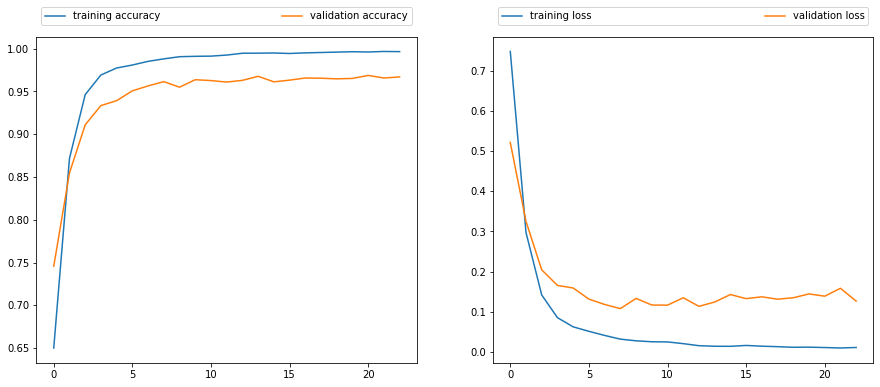

In [27]:
plot_history(history)

In [28]:
import numpy as np

pred_y = model_final.predict(test_generator)

In [29]:
pred_y = pred_y > 0.5
pred_y[0]

array([ True,  True, False,  True,  True,  True, False, False,  True,
       False,  True, False, False, False,  True, False,  True,  True,
        True,  True])

In [30]:
true_y = test_df['class']
true_y[0]

[19, 18, 17, 16, 14, 10, 8, 5, 4, 3, 2, 1, 0]

In [31]:
bt = [0] * 20
bf = [0] * 20
fp = [0] * 20
fn = [0] * 20

for t_y, p_y in zip(true_y, pred_y):
    p_y = np.where(p_y)[0]
    for i in range(20):
        if i in t_y and i in p_y:
            bt[i] += 1
        elif i not in t_y and i not in p_y:
            bf[i] += 1
        elif i in t_y and i not in p_y:
            fn[i] += 1
        else:
            fp[i] += 1
print("true positive:", bt, "\ntrue negative:", bf, "\nfalse positive:", fp, "\nfalse negative:", fn)

true positive: [107, 116, 96, 101, 85, 83, 94, 95, 96, 91, 100, 98, 96, 92, 86, 86, 99, 96, 111, 114] 
true negative: [83, 73, 94, 92, 109, 107, 100, 100, 98, 96, 88, 96, 99, 102, 109, 108, 94, 94, 81, 81] 
false positive: [0, 10, 3, 5, 2, 4, 3, 3, 1, 3, 11, 3, 4, 1, 2, 3, 3, 3, 2, 2] 
false negative: [10, 1, 7, 2, 4, 6, 3, 2, 5, 10, 1, 3, 1, 5, 3, 3, 4, 7, 6, 3]


In [32]:
model_final.evaluate(test_generator)

7/7 [==============================] - 3s 439ms/step - loss: 0.1077 - binary_accuracy: 0.9615


[0.10767509788274765, 0.9614999890327454]

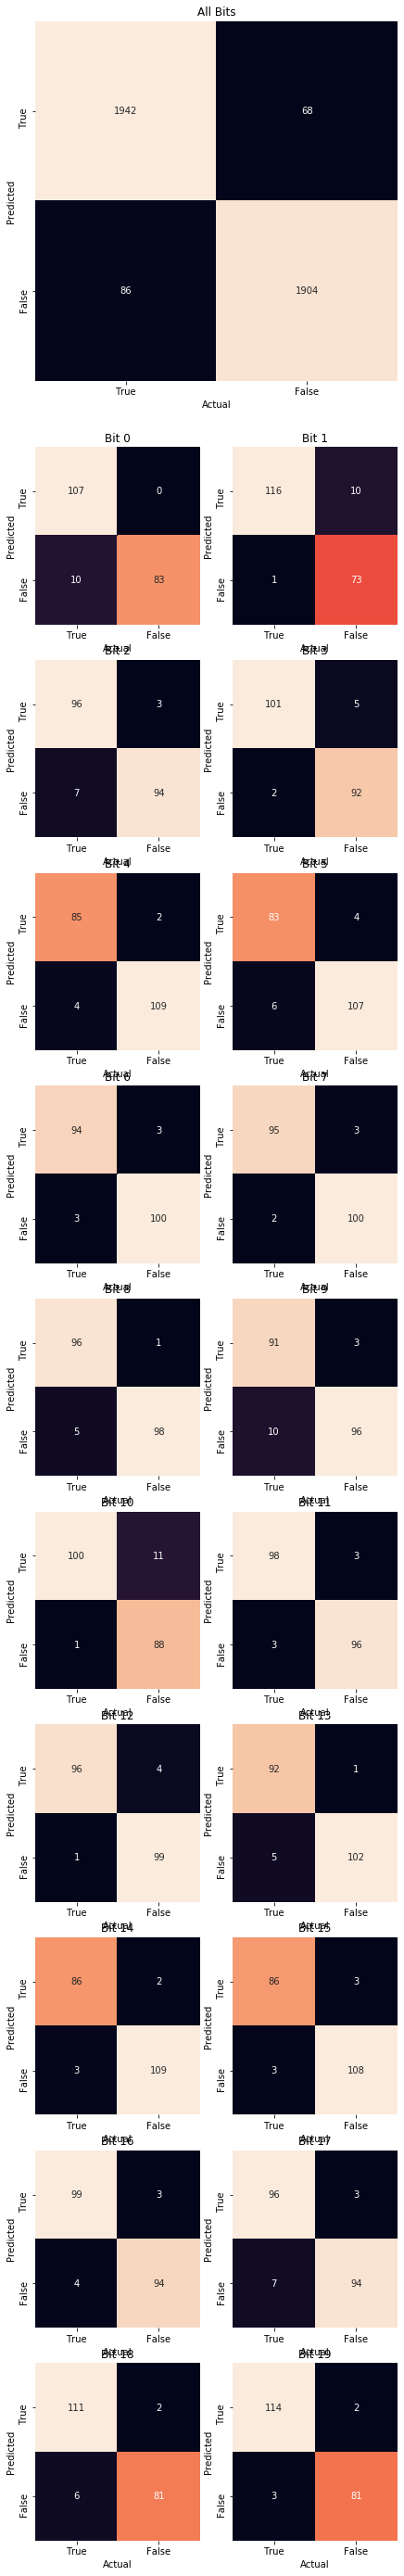

In [33]:
import seaborn as sns

f = plt.figure(figsize = (7,50))
sum_ax = f.add_subplot(6, 1, 1)
sns.heatmap([[sum(bt), sum(fp)], 
             [sum(fn), sum(bf)]],
            annot = True, 
            cbar = False,
            xticklabels = ["True", "False"], 
            yticklabels = ["True", "False"],
            ax = sum_ax,
            fmt='d')
sum_ax.set_title('All Bits')
sum_ax.set_ylabel("Predicted")
sum_ax.set_xlabel("Actual")

for i in range(20):
    ax = f.add_subplot(12, 2, i + 5)
    sns.heatmap([[bt[i], fp[i]], 
                 [fn[i], bf[i]]],
                annot = True, 
                cbar = False,
                xticklabels = ["True", "False"], 
                yticklabels = ["True", "False"],
                ax = ax,
                fmt='d')
    ax.set_title('Bit {}'.format(i))
    ax.set_ylabel("Predicted")
    ax.set_xlabel("Actual")

## Save model

In [ ]:
model_final.save('bar_cat_EfficientNetB1_last_trained_9615')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
